# Tensor Flow Regression
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import tensorflow as tf
train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')


2023-05-02 00:27:46.671984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [2]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    ## Log the Budget
    train_df['budget'] = train_df['budget'].apply(lambda x: np.log1p(x)) 
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [3]:
train_df = normalize(train_df)
test_df = normalize(test_df)
train_df

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,...,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,16.454568,6.575393,93.0,12314651,1,1,1,0,0,0,...,0,0,0,0,0,72,24,3,1,2
1,17.504390,8.248895,113.0,95149435,1,1,1,0,0,0,...,0,0,0,0,0,9,20,1,1,8
2,15.009433,64.299990,105.0,13092000,1,1,1,0,0,0,...,0,0,0,0,0,64,51,3,1,10
3,13.997833,3.174936,122.0,16000000,2,0,1,0,0,0,...,0,0,1,0,0,3,7,0,0,3
4,0.000000,1.148070,118.0,3923970,1,0,1,1,0,0,...,0,0,1,0,0,2,4,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,9.853270,102.0,1596687,1,1,1,0,0,0,...,0,0,0,0,0,17,15,2,1,4
2996,0.000000,3.727996,102.0,180590,1,0,2,0,0,0,...,0,0,0,0,0,15,11,2,0,3
2997,17.989898,14.482345,120.0,89456761,1,1,1,1,0,0,...,0,0,1,0,0,10,15,3,1,10
2998,17.553180,15.725542,90.0,171963386,1,1,1,0,0,0,...,0,0,0,0,0,89,26,2,1,1


In [4]:
# import tool
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = pd.DataFrame(train_df['revenue'])

# scale feature data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2100, 31)
(900, 31)
(2100, 1)
(900, 1)


### Define Model

In [5]:
model = Sequential()
input_size = 31
hidden_neurons = 300
out_size = 1

model.add(Dense(hidden_neurons, input_dim = input_size))  # Nuerons
model.add(Activation('tanh')) # Activation

model.add(Dense(out_size, input_dim = hidden_neurons))  # Nuerons
model.add(Activation('relu')) # Activation


2023-05-01 23:32:47.475916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 23:32:47.476684: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [5]:
model= Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    Dense(300, activation='tanh'),
    Dense(300, activation='tanh'),
    Dense(300, activation='relu'),
    Dense(1)
])

2023-05-02 00:28:01.026018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 00:28:01.026964: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [6]:
model.compile(loss='mae',
              metrics=['mae'],
              optimizer='adam')

In [ ]:
fitted_model = model.fit(X_train, y_train, validation_split=0.50, batch_size=32, epochs=1000, verbose=1)

In [8]:
y_predict = model.predict(X_test, verbose=1)

29/29 [==============================] - 0s 3ms/step


In [9]:
score = model.evaluate(X_test, y_test, verbose=1)
print('The accuracy is: ', score[1])

29/29 [==============================] - 0s 4ms/step - loss: 0.3242 - mae: 0.3242
The accuracy is:  0.32421374320983887


## Plot Results

R2 : 0.58335560993426 
RMSE: 78979683.3235941


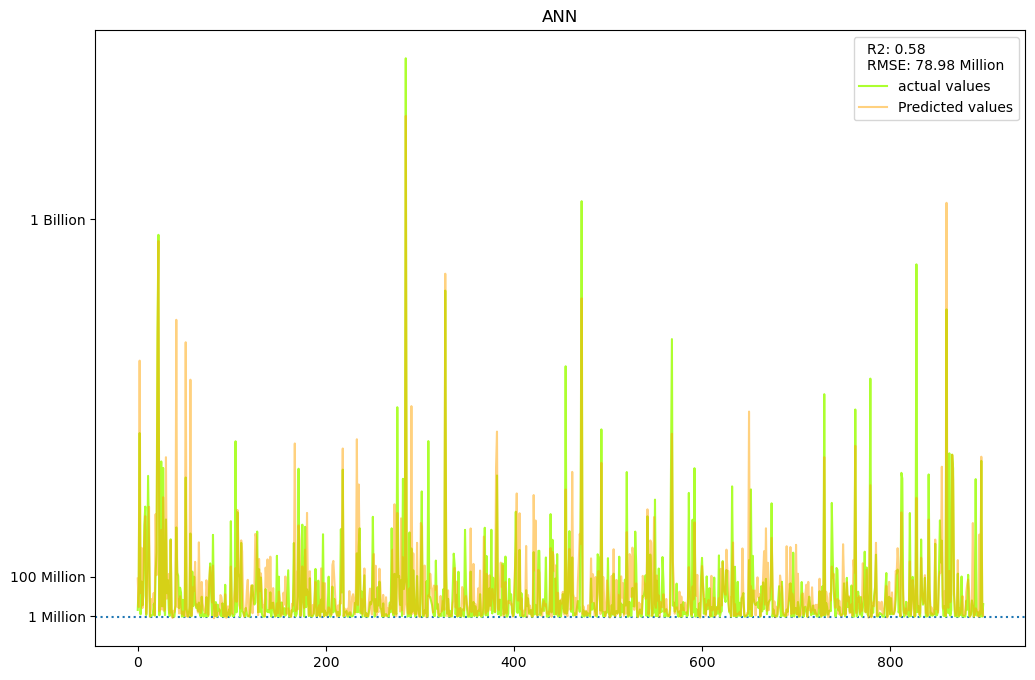

In [10]:
y_predict = sc_y.inverse_transform(pd.DataFrame(y_predict)) 
y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 
plt.figure(figsize=(12, 8))
plt.title("ANN")
plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])
# Draw line for 0 values
plt.axhline(y=0, linestyle='dotted')
# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.plot([i for i in range(len(y_test))],y_predict, label="Predicted values", c='orange',alpha=0.5,zorder=10)



mse_score = metrics.mean_squared_error(y_test, y_predict)
rmse_score = np.sqrt(mse_score)
r2_score = r2_score(y_test,y_predict)
print( f"R2 : {r2_score} \nRMSE: {rmse_score}")
plt.legend(title=f"R2: {r2_score:.2f}\nRMSE: {(rmse_score/1000000):.2f} Million")
plt.show()

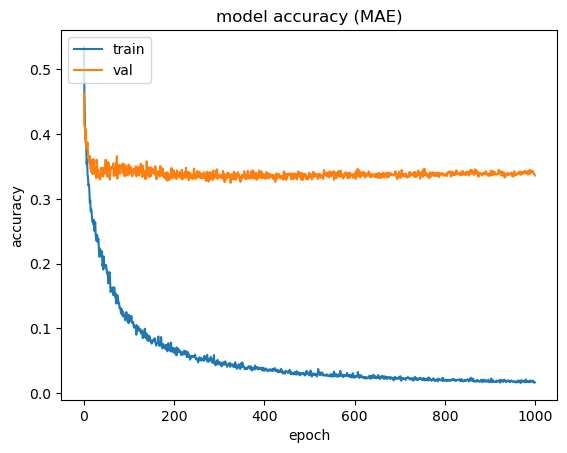

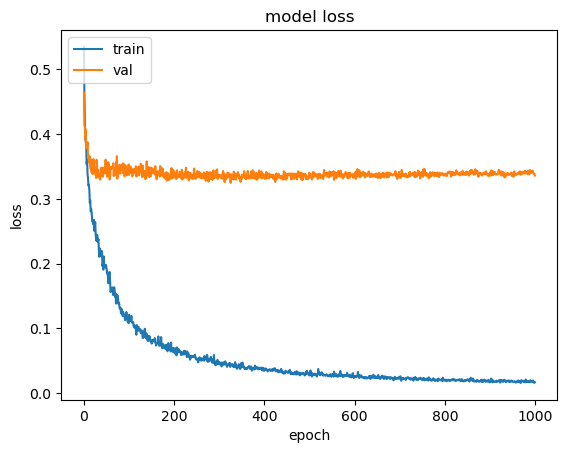

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(fitted_model.history['mae'])
plt.plot(fitted_model.history['val_mae'])
plt.title('model accuracy (MAE)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# print(fitted_model.history)
